In [1]:
import warnings
import pandas as pd
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
import numpy as np
from shutil import copy2 as copy
from IPython.display import display, HTML
from math import floor, ceil
import json
import re
import os

from IPython.display import HTML, display

pd.set_option('display.max_rows', None)

secrets = json.load(open('secrets.json'))
game_version = secrets['game_version']
os.makedirs(game_version, exist_ok=True)

# Sacred Stones Weapons

In [ ]:
wp = pd.read_csv("data/weapons_ss.csv",sep='\s*?,\s*?', engine='python')
wp['Tags'] = wp.Tags.fillna('')

numeric = ['Mt','Wt']
# rng_map = {'1':1, '1~2':3, '2':2, '2~3':5, '1~3':4, '3~10':13, 'All':20, '1~Mag/A':10, '1~Mag/B':10,
#     '1~/Mag/B':10, '1~Mag/C':10, '1~Mag/D':10}
# rng_unmap = {1:'1', 3:'1~2', 2:'2', 5:'2~3', 4:'1~3', 13:'3~10', 20:'All', 10:'1~Str', 10:'1~Str',
#     10:'1~Str', 10:'1~Str', 10:'1~Str'}
# rng_norms = {"Swords": 1, "Lances": 1, "Axes": 1, "Bows": 2, "Reason": 3, "Dark": 3, "Faith": 3}

normal_wp = wp.loc[~wp.Tags.str.contains('Legendary') & (wp.Type != 'Monster')]

wp_tiers = normal_wp[['Name', 'Type']].copy()
for type in set(normal_wp['Type']):
    wp_tiers.loc[wp_tiers.Type == type, 'Mt'] = pd.cut(normal_wp.loc[wp.Type == type, 'Mt'], 5, retbins=True, labels=['0', '1', '2', '3', '4'])[0]
    wp_tiers.loc[wp_tiers.Type == type, 'Wt'] = pd.cut(normal_wp.loc[wp.Type == type, 'Wt'], 5, retbins=True, labels=['-2', '-1', '0', '1', '2'])[0]
wp_tiers['Mt'] = wp_tiers['Mt'].astype('str').str.replace('nan', '0')
wp_tiers['Wt'] = wp_tiers['Wt'].astype('str').str.replace('nan', '0')
wp_tiers = wp_tiers.merge(wp[['Name', 'Rng', 'DmgType', 'Tags']], on='Name').fillna('')

wp_tiers.loc[wp_tiers.Name == 'Iron Sword', 'Mt'] = '1' 
wp_tiers.loc[wp_tiers.Name == 'Shine', 'Wt'] = '-1' 

wp_tiers.sort_values('Mt')
wp_tiers[wp_tiers.Type=='Faith']

In [ ]:
export = wp_tiers.copy()
# export["Atk"] = export.apply(lambda x: x.Mag if x.Mag != '-' else x.Str, axis=1)
# export['HP'] = 20
export_order = ['Name', 'Type', 'Mt', 'Wt', 'Rng', 'DmgType', 'Tags']
export = export[export_order].sort_values('Type')
export.to_csv(f'{game_version}/weapons_ss.csv', index=False)
md_table = export.to_markdown(index=0)
open(f'{game_version}/Weapons.md', 'w').write(md_table)
open(f'{secrets["ObsidianRoot"]}/{game_version}/Weapons.md', 'w').write(md_table)
print(md_table)

# Engage Weapons

In [2]:
def fix(df, check, pattern, target, value):
    df.loc[df[check].str.contains(pattern), target] = value

def adjust(df, check, pattern, target, value):
    df.loc[df[check].str.contains(pattern), target] = df.loc[df[check].str.contains(pattern), target]+value


engage_raw = pd.read_csv("data/engage_weapons_groom.csv",sep='\s*?,\s*?', engine='python')
engage_raw['Tags'] = engage_raw.Tags.fillna('')
numeric = ['Mt', 'Hit', 'Crit', 'Wt']
slicekey = 'Type'

# Raw data adjustments and filters

engage_raw.loc[engage_raw.Name.str.contains("urge"), "Hit"] = 100
# engage_raw.loc[engage_raw.Name.str.contains("Meteor"), "Wt"] = 15
# engage_raw.loc[engage_raw.Wt > 20, "Wt"] = 20

# Rating generation

wp_tiers = engage_raw[['Name', slicekey]].copy()
for type in set(engage_raw[slicekey]):
    
    # Might 
    
    base, rank_climb, type_diff = 4, 2, 1
    wp_tiers.loc[wp_tiers[slicekey] == type, 'Mt'] = engage_raw.loc[wp_tiers[slicekey] == type, 'Lvl'].map({'C':base, 'B':base+rank_climb*1, 'A':base+rank_climb*2, 'S':base+rank_climb*3})
    
    if type in ['Sword']: 
        wp_tiers.loc[wp_tiers[slicekey] == type, 'Mt'] = wp_tiers.loc[wp_tiers[slicekey] == type, 'Mt'] - type_diff
    
    if type in ['Dagger']: 
        wp_tiers.loc[wp_tiers[slicekey] == type, 'Mt'] = wp_tiers.loc[wp_tiers[slicekey] == type, 'Mt'] - type_diff*3
    elif type in ['Axe']: 
        wp_tiers.loc[wp_tiers[slicekey] == type, 'Mt'] = wp_tiers.loc[wp_tiers[slicekey] == type, 'Mt'] + type_diff
    # elif type in ['Art']: 
    #     wp_tiers.loc[wp_tiers[slicekey] == type, 'Mt'] = wp_tiers.loc[wp_tiers[slicekey] == type, 'Mt'] - type_diff*3
    
    # Weight
    if type == 'Staff':
        wp_tiers.loc[wp_tiers[slicekey] == type, 'Wt'] = '0'
    else:
        med = min(int(engage_raw.loc[engage_raw[slicekey] == type, 'Wt'].median()), 13)
        high = 14
        
        wp_tiers.loc[wp_tiers[slicekey] == type, 'Wt'] = pd.cut(engage_raw.loc[engage_raw[slicekey] == type, 'Wt'], [0, med, high, 99], retbins=True, labels=['0', '-5', '-10'])[0]
wp_tiers.Mt = wp_tiers.Mt.astype('int')

wp_tiers['Mt'] = wp_tiers['Mt'].astype('str').str.replace('nan', '0')
wp_tiers['Wt'] = wp_tiers['Wt'].astype('str').str.replace('nan', '0')
wp_tiers['Hit'] = engage_raw.Hit.apply(lambda x: -max(80-x, 0)) # Incease _-x to be more penalizing
wp_data = wp_tiers.merge(engage_raw, on=[slicekey, 'Name'], suffixes=[None, 'Value']).fillna('')
wp_data.Mt = wp_data.Mt.astype('int')
wp_data.Wt = wp_data.Wt.astype('int')
wp_data.Hit = wp_data.Hit.astype('int')

# Spot data tuning

lvl_cats = pd.api.types.CategoricalDtype(
    ['S', 'A', 'B', 'C', 'D'], 
    ordered=True
)
wp_data.Lvl = wp_data.Lvl.astype(lvl_cats)
type_cats = pd.api.types.CategoricalDtype(
    ['Sword', 'Axe', 'Lance', 'Bow', 'Dagger', 'Art', 'Tome', 'Staff'], 
    ordered=True
)
wp_data.Type = wp_data.Type.astype(type_cats)
wp_data.loc[wp_data.Name.str.contains("urge"), "Hit"] = 100
wp_data.loc[wp_data.Type.str.contains("Staff"), "Mt"] = 0
wp_data.Price = wp_data.Price/100
adjust(wp_data, 'Name', '(Javelin|Hand Axe)', 'Mt', -2)
adjust(wp_data, 'Name', '(Javelin|Hand Axe)', 'Hit', -5)
adjust(wp_data, 'Name', '(Javelin|Hand Axe)', 'Wt', -5)
wp_data.loc[wp_data.Tags.str.contains('Brave'), 'Mt'] = (wp_data.loc[wp_data.Tags.str.contains('Brave'), 'Mt']/3).apply(np.floor)
wp_data["DmgType"] = wp_data.apply(lambda x: 'Mag' if x.Type in ['Tome', 'Staff'] else 'Phys',axis=1)
wp_data["DmgType"] = wp_data.apply(lambda x: 'Mag' if 'Enchanted' in x.Tags else x.DmgType,axis=1)

# # adjust(wp_data, 'Name', '(Killer Lance|Rider|Hammer|Poleaxe)', 'Mt', 2)
# fix(wp_data, 'Name', 'Radiant', 'Mt', 7)
# # wp_data.loc[wp_data.Type.str.contains('Tome'), 'Mt'] = wp_data.loc[wp_data.Type.str.contains('Tome'), 'Mt'].clip(upper=7)

# # Export 

wp_data.Wt = wp_data.Wt.astype('int')
export = wp_data.copy()
export_order = ['Type', 'Name', 'Lvl', 'Mt', 'Wt', 'Hit', 'Rng', 'DmgType', 'Price', 'Tags']
export = export[export_order].sort_values(['Type', 'Lvl'])

# # ---

export.sort_values(['Type', 'Wt'], ascending=True)
# export.sort_values(['Wt'], ascending=True)
# wp_data[wp_data.Type == 'Sword'].sort_values(['Lvl', 'Mt'], ascending=True)
export[export.Type == 'Dagger'].set_index(['Lvl', 'Name', 'Mt']).sort_index(level=[0,2])
# export[export.Name.str.contains('Silver|Steel|Iron|Slim|Compact|Initiate|Short')].sort_values(['Type', 'Mt'], ascending=True)
# export[export.Tags.str.contains('Brave')].sort_values(['Type', 'Mt'], ascending=True)
# s_ranks

/var/folders/ks/dksml1ms0rg9dk9rjyqpnfdc0000gn/T/ipykernel_29254/2166989623.py:5: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df.loc[df[check].str.contains(pattern), target] = df.loc[df[check].str.contains(pattern), target]+value


Type  Wt  Hit  Rng DmgType  Price  \
Lvl Name          Mt                                        
S   Carnwenhan    7   Dagger  -5    0    1    Phys  100.0   
    Cinquedea     7   Dagger  -5    0  1~2    Phys  100.0   
A   Peshkatz      5   Dagger  -5    0    1    Phys   40.0   
    Silver Dagger 5   Dagger   0    0  1~2    Phys   40.0   
B   Stiletto      3   Dagger   0   -5    1    Phys   20.0   
C   Steel Dagger  1   Dagger   0    0  1~2    Phys   20.0   

                                             Tags  
Lvl Name          Mt                               
S   Carnwenhan    7        Heavy Status(Poisoned)  
    Cinquedea     7              Status(Poisoned)  
A   Peshkatz      5   Deadly(15) Status(Poisoned)  
    Silver Dagger 5              Status(Poisoned)  
B   Stiletto      3   Deadly(15) Status(Poisoned)  
C   Steel Dagger  1              Status(Poisoned)

In [3]:
export.to_csv(f'{game_version}/weapons_engage.csv', index=False)
md_table = ''
for g, data in export.groupby(['Type']):
    md_table += f'## {g}\n\n'
    md_table += data.to_markdown(index=0)+'\n\n'
# md_table = export.to_markdown(index=0)
open(f'{game_version}/Weapons.md', 'w').write(md_table)
open(f'{secrets["ObsidianRoot"]}/{game_version}/Weapons.md', 'w').write(md_table)
# print(md_table)

11204

In [279]:
df = pd.DataFrame()

ATK, DEF, WP                 = 4, 0, 4
ATKSCALE, DEFSCALE, WPSCALE  = 1, 2, 2
HPSTART, HPSCALE, HPBASE = -6, 2, 35

stats = 'F E D C B A S'.split(' ')
wps = 'C B A S'.split(' ')

reference = pd.DataFrame()
reference['Atk'] = [i+ATK for i in range(0, len(stats)*ATKSCALE, ATKSCALE)]
reference['Def'] = [i+DEF for i in range(0, len(stats)*DEFSCALE, DEFSCALE)]
reference['Def'] = [1, 1, 2, 3, 5, 8, 12]
reference['Wp'] = [0,0,0]+[i+WP for i in range(0, len(wps)*WPSCALE, WPSCALE)]
reference['Hp'] = [HPBASE+i for i in range(HPSTART, HPSTART+(7*HPSCALE), HPSCALE)]
reference['Rating'] = stats
reference = reference.set_index('Rating')

for av, astat in zip(reference['Atk'], stats):
    for wv, wp in zip(reference['Wp'][3:], wps):
        for dv,dstat in zip(reference['Def'], stats):
            calc = pd.Series({
                    'AR': astat,
                    'WP': wp,
                    "DFR": dstat,
                    "DM": av,
                    "MT": wv,
                    "DM+MT": av+wv,
                    "DR": dv,
                    "Total": av+wv-dv
                    }).to_frame().T
            df = pd.concat([df, calc])

lvl_cats = pd.api.types.CategoricalDtype(
    ['S', 'A', 'B', 'C', 'D', 'E', 'F'], 
    ordered=True
)
wp_lvl_cats = pd.api.types.CategoricalDtype(
    ['S', 'A', 'B', 'C'], 
    ordered=True
)
df['AR'] = df['AR'].astype(lvl_cats)
df['DFR'] = df['DFR'].astype(lvl_cats)
df['WP'] = df['WP'].astype(wp_lvl_cats)

print(reference)
df = df.set_index(['AR', 'WP', 'DFR'])
print("Plinks")
display(HTML(df.loc[df.Total <= 0].to_html())) # Plinks
print("ORKO")
display(HTML(df.loc[df.Total >= 21].to_html())) # ORKO
df.loc[('A', 'A')]
df.loc[('A')]
df.groupby(['AR', 'WP']).Total.agg([min,max]).clip(lower=0).mean(axis=1).to_frame()
df
# df.groupby(['AR', 'DFR']).Total.agg([min,max]).clip(lower=0).mean(axis=1).to_frame()

# Scale between min and max is ATKSCALE

        Atk  Def  Wp  Hp
Rating                  
F         4    1   0  29
E         5    1   0  31
D         6    2   0  33
C         7    3   4  35
B         8    5   6  37
A         9    8   8  39
S        10   12  10  41
Plinks


ORKO


,,,DM,MT,DM+MT,DR,Total
AR,WP,DFR,,,,,


DM  MT DM+MT  DR Total
AR WP DFR                        
F  C  F     4   4     8   1     7
      E     4   4     8   1     7
      D     4   4     8   2     6
      C     4   4     8   3     5
      B     4   4     8   5     3
      A     4   4     8   8     0
      S     4   4     8  12    -4
   B  F     4   6    10   1     9
      E     4   6    10   1     9
      D     4   6    10   2     8
      C     4   6    10   3     7
      B     4   6    10   5     5
      A     4   6    10   8     2
      S     4   6    10  12    -2
   A  F     4   8    12   1    11
      E     4   8    12   1    11
      D     4   8    12   2    10
      C     4   8    12   3     9
      B     4   8    12   5     7
      A     4   8    12   8     4
      S     4   8    12  12     0
   S  F     4  10    14   1    13
      E     4  10    14   1    13
      D     4  10    14   2    12
      C     4  10    14   3    11
      B     4  10    14   5     9
      A     4  10    14   8     6
      S     4  10    14  12     2
E  C  F     5   4     9   1     8
      E     5   4     9   1     8
      D     5   4     9   2     7
      C     5   4     9   3     6
      B     5   4     9   5     4
      A     5   4     9   8     1
      S     5   4     9  12    -3
   B  F     5   6    11   1    10
      E     5   6    11   1    10
      D     5   6    11   2     9
      C     5   6    11   3     8
      B     5   6    11   5     6
      A     5   6    11   8     3
      S     5   6    11  12    -1
   A  F     5   8    13   1    12
      E     5   8    13   1    12
      D     5   8    13   2    11
      C     5   8    13   3    10
      B     5   8    13   5     8
      A     5   8    13   8     5
      S     5   8    13  12     1
   S  F     5  10    15   1    14
      E     5  10    15   1    14
      D     5  10    15   2    13
      C     5  10    15   3    12
      B     5  10    15   5    10
      A     5  10    15   8     7
      S     5  10    15  12     3
D  C  F     6   4    10   1     9
      E     6   4    10   1     9
      D     6   4    10   2     8
      C     6   4    10   3     7
      B     6   4    10   5     5
      A     6   4    10   8     2
      S     6   4    10  12    -2
   B  F     6   6    12   1    11
      E     6   6    12   1    11
      D     6   6    12   2    10
      C     6   6    12   3     9
      B     6   6    12   5     7
      A     6   6    12   8     4
      S     6   6    12  12     0
   A  F     6   8    14   1    13
      E     6   8    14   1    13
      D     6   8    14   2    12
      C     6   8    14   3    11
      B     6   8    14   5     9
      A     6   8    14   8     6
      S     6   8    14  12     2
   S  F     6  10    16   1    15
      E     6  10    16   1    15
      D     6  10    16   2    14
      C     6  10    16   3    13
      B     6  10    16   5    11
      A     6  10    16   8     8
      S     6  10    16  12     4
C  C  F     7   4    11   1    10
      E     7   4    11   1    10
      D     7   4    11   2     9
      C     7   4    11   3     8
      B     7   4    11   5     6
      A     7   4    11   8     3
      S     7   4    11  12    -1
   B  F     7   6    13   1    12
      E     7   6    13   1    12
      D     7   6    13   2    11
      C     7   6    13   3    10
      B     7   6    13   5     8
      A     7   6    13   8     5
      S     7   6    13  12     1
   A  F     7   8    15   1    14
      E     7   8    15   1    14
      D     7   8    15   2    13
      C     7   8    15   3    12
      B     7   8    15   5    10
      A     7   8    15   8     7
      S     7   8    15  12     3
   S  F     7  10    17   1    16
      E     7  10    17   1    16
      D     7  10    17   2    15
      C     7  10    17   3    14
      B     7  10    17   5    12
      A     7  10    17   8     9
      S     7  10    17  12     5
B  C  F     8   4    12   1    11
      E     8   4    12   1    11
      D     8   4    12   2    10
      C     8   4    12   3     9

<AxesSubplot: xlabel='Number of Attacks to Kill', ylabel='Hp-((Atk+Wp)-Def) Combinations (245)'>

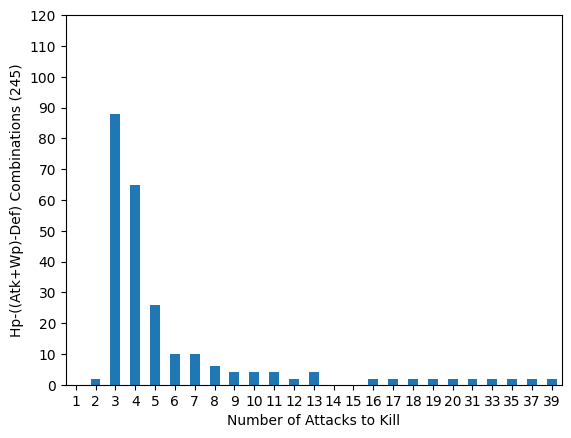

In [280]:
avg = df.groupby(['AR', 'DFR']).Total.agg([min,max]).clip(lower=0).mean(axis=1).to_frame()
avg[0] = avg[0].astype(int)
for lv in stats[1:-1]:
    v = reference['Hp'][lv]
    avg[f'HP-{v}'] = (v/avg[0]).apply(np.ceil)
avg = avg.rename({0:"Avg Damage"},axis=1)
cnts = avg.apply(pd.Series.value_counts).fillna(0)
cnts['Totals'] = cnts.iloc[:, 1:].sum(axis=1)
cnts = cnts.set_index(cnts.index.astype('int'))
cnts = cnts.astype('int')
pct = cnts['HP-33'].sum()*5
cnts['Percent'] = (cnts['Totals']/pct).round(1)
display(HTML(avg.to_html()))
cnts['Totals'].plot.bar(
                        xlabel='Number of Attacks to Kill', 
                        ylabel=f'Hp-((Atk+Wp)-Def) Combinations ({pct})', 
                        rot=0, 
                        yticks=[i for i in range(0,130,10)]
                        )
# cnts['Percent'].plot.pie()